# Sentiment Analysis - BERT training

### Imports

In [1]:
#!pip install -qq transformers
#!pip install -qq watermark
#!pip install torch torchvision torchaudio
#!pip install wandb

In [37]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import math
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OrdinalEncoder
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import wandb

### Configure

Libraries settings

In [38]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [39]:
wandb.init(project="histaware")

Running settings

In [81]:
LEN_SENTS = 75

### Imports

In [129]:
df = pd.read_csv("sentiment/edo_1990s_gas_labeled.csv")
df = df[df.energy == "Y"]

wandb.config.dataset = "edo_1990s_gas_labeled"

In [83]:
df.shape

(368, 24)

#### Encode labels

In [84]:
cleanup_sentiment = {"sentiment": {"VN": 1, "NG": 2, "NE": 3, "PO": 4, "VP": 5}}
df = df.replace(cleanup_sentiment)

Text(0.5, 0, 'review sentiment')

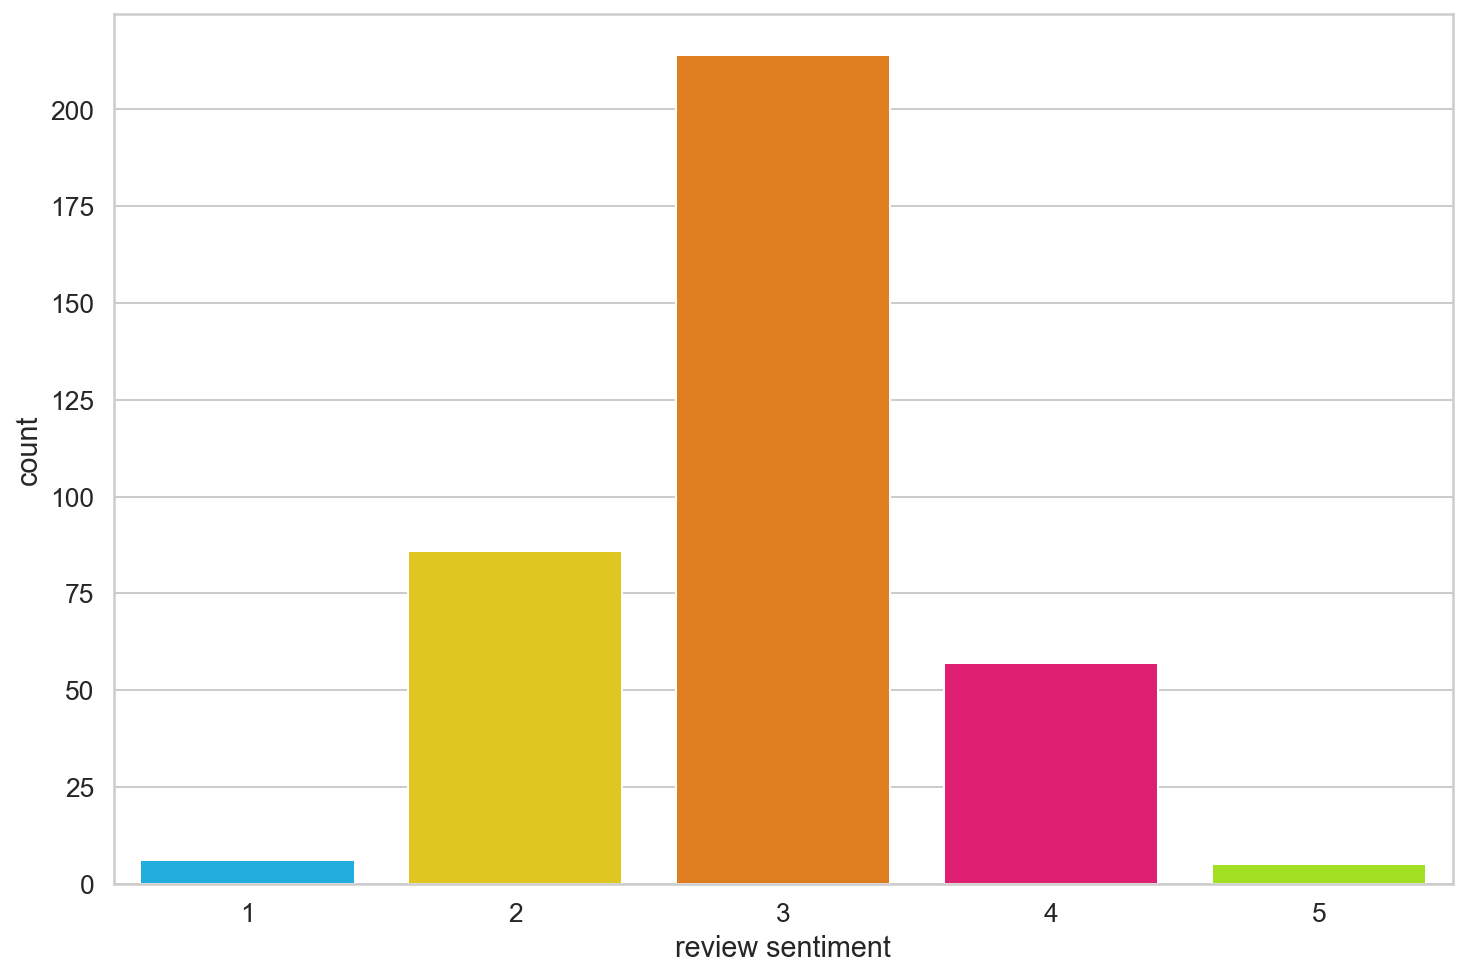

In [85]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')

Reduce from 5 to 3

In [86]:
def to_sentiment(rating):
    rating = int(rating)
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2

df['sentiment'] = df.sentiment.apply(to_sentiment)

Text(0.5, 0, 'review sentiment')

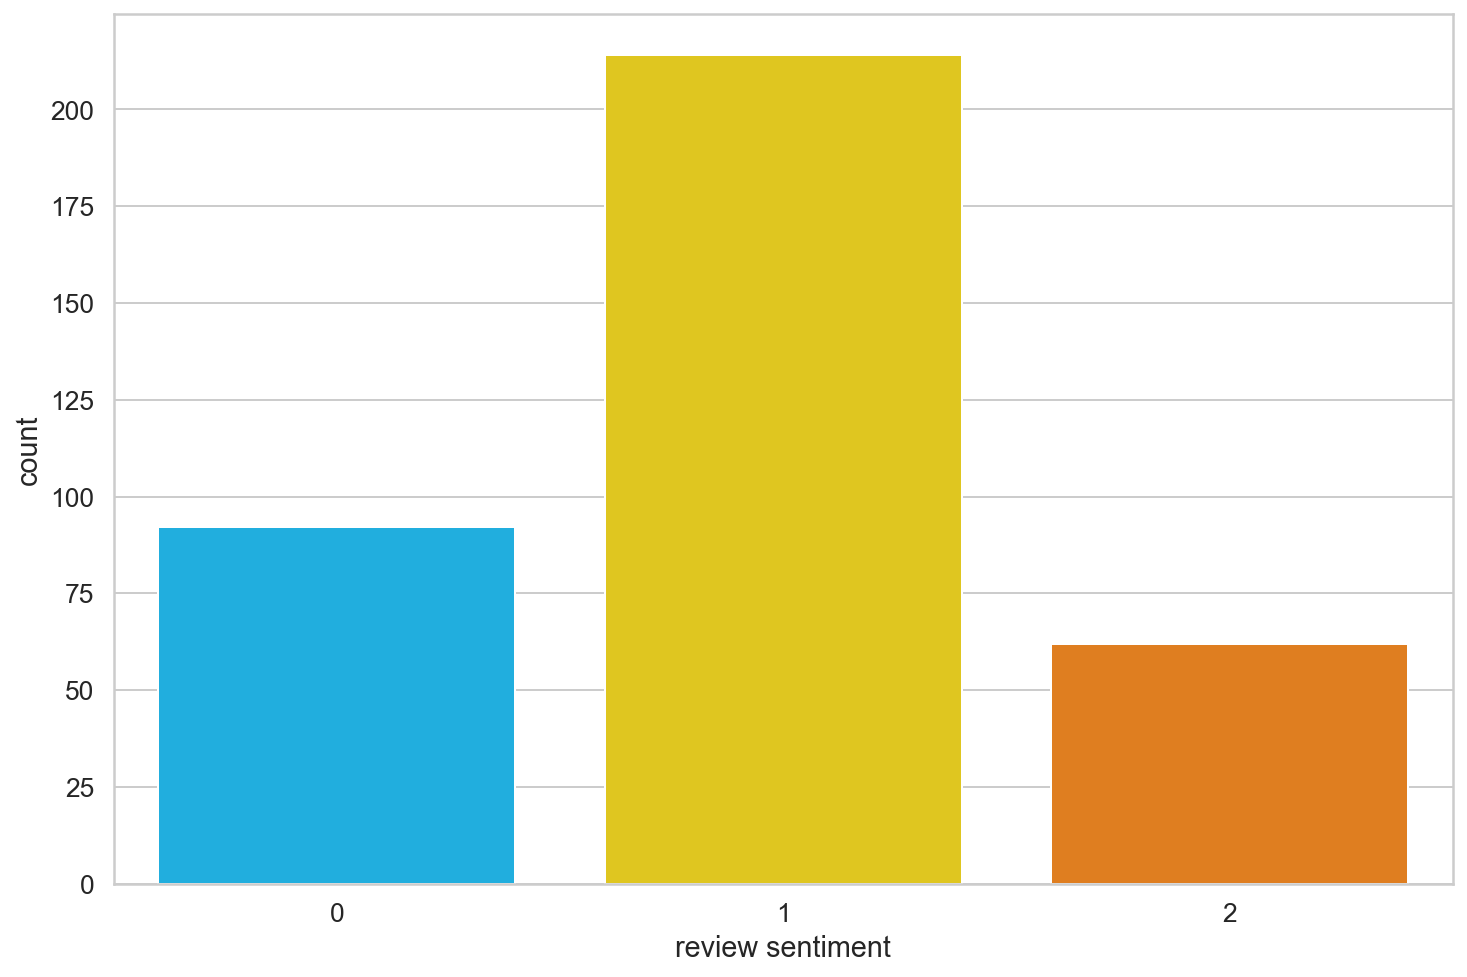

In [87]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')

### Split text and explode

In [88]:
import nltk.data
from nltk.tokenize import sent_tokenize
from nltk.corpus import alpino

In [89]:
def unite(l, n):
    """Unite sentences previously split using nltk.tokenize."""
    count = []
    chunks = []
    sents = []
    for s in l:
        count.append(len(s.split()))
    value = 0
    prev_idx = 0
    for i in range(0, len(count)):
        if value == 0:
            value = value + count[i]
        elif (i+1 == len(count)):
            chunks.append(l[prev_idx:i])
            value = 0
        elif value >= n:
            chunks.append(l[prev_idx:i])
            prev_idx = i
            value = 0
        else:
             value = value + count[i]
    for c in chunks:
        sents.append(' '.join(c))
    return(sents)

In [90]:
def splitter(s, n):
    """Split sentences only using the number of words."""
    pieces = s.split()
    return [" ".join(pieces[i:i+n]) for i in range(0, len(pieces), n)]

In [91]:
df["text_split"] = df["text"].apply(sent_tokenize)
df["text_split"] = df["text_split"].apply(unite, n = LEN_SENTS)

# Currently not splitting the cleaned sentences
#df["text_clean_split"] = df["text_clean"].apply(splitter, n = LEN_SENTS)

### Max token length 

In [92]:
MAX_LEN = 0
def max_len(x):
    lengths = []
    for i in x:
        lengths.append(len(i.split()))
    return(max(lengths))
    
temp = df["text_split"].apply(max_len)
MAX_LEN = max(temp)
print(MAX_LEN)

In [93]:
MAX_LEN

316

In [94]:
df = df.explode('text_split')
df.shape

(925, 25)

### Pre-trained wietsedv BERT

In [95]:
PRE_TRAINED_MODEL_NAME = 'wietsedv/bert-base-dutch-cased'

In [96]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [100]:
token_lens = []
for txt in df.text_split:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

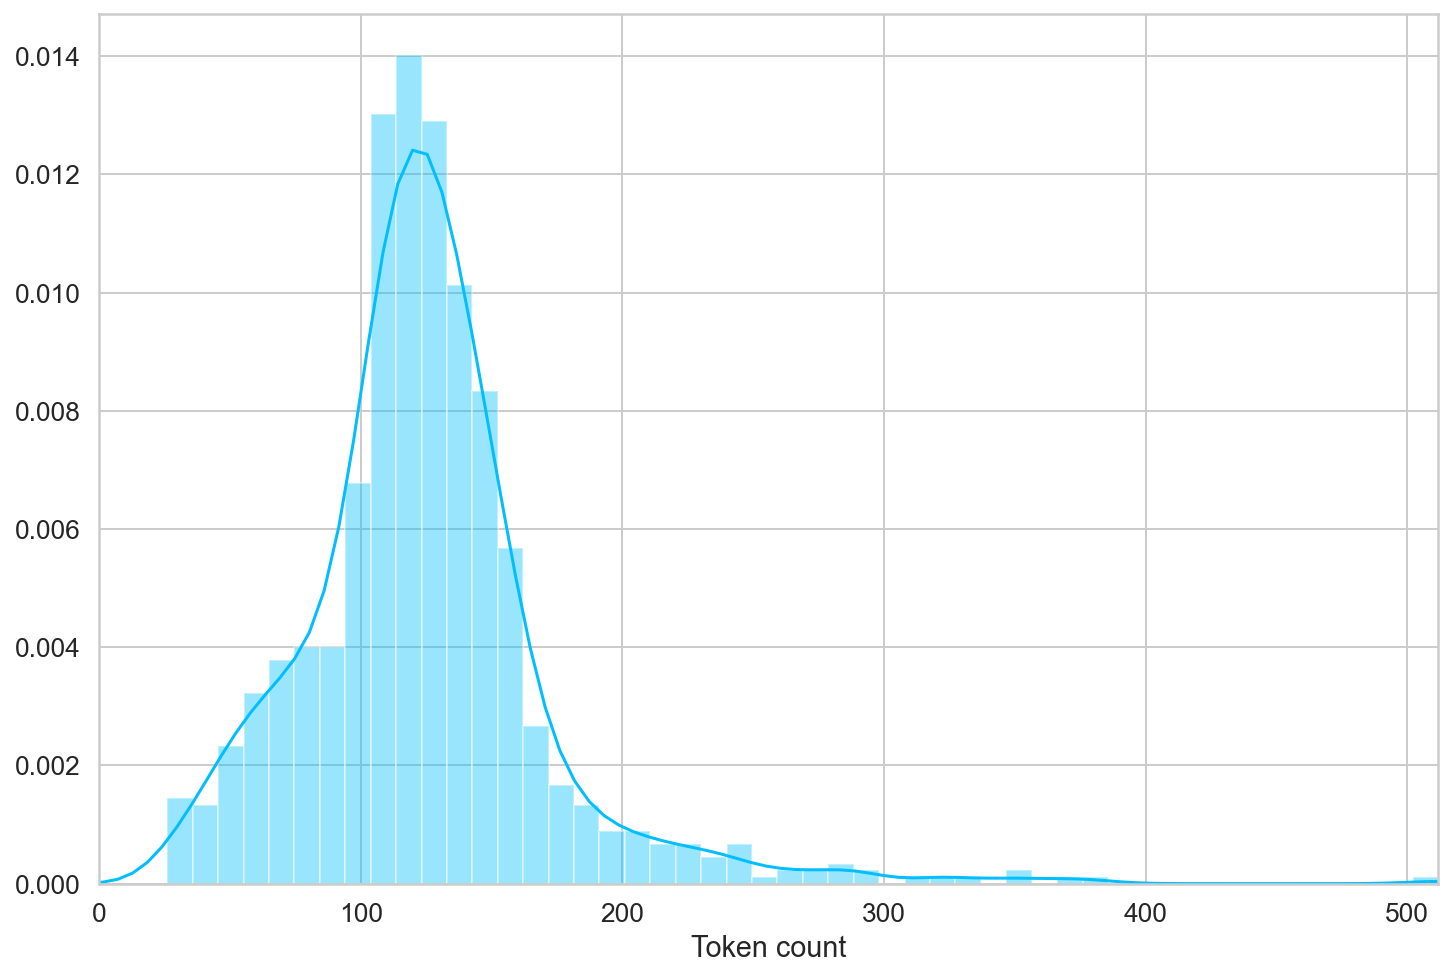

In [101]:
sns.distplot(token_lens)
plt.xlim([0, 512]);
plt.xlabel('Token count');

In [102]:
class HADataset(Dataset):
    # Characterizes a dataset for Pytorch
    def __init__(self, articles, labels, tokenizer, max_len):
        # Initialization
        self.articles = articles
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        # Total number of articles
        return len(self.articles)

    def __getitem__(self, item):
        # Generates one sample of the data/article
        article = str(self.articles[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            article,
            add_special_tokens=True,
            padding='max_length',
            max_length=self.max_len,
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
          'article_text': article,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'labels': torch.tensor(label, dtype=torch.long)
        }

In [103]:
df_train, df_test = train_test_split(
  df,
  test_size=0.25,
  random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

In [118]:
def create_data_loader(df, tokenizer, batch_size, num_workers):
    ds = HADataset(
        articles=df.text_split.to_numpy(),
        labels=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=400
      )
    
    return DataLoader(
        ds,
        batch_size,
        num_workers
      )

In [130]:
# Parameters
batch_size = 16
num_workers = 6
max_epochs = 100

# WandB
wandb.config.batch_size = batch_size
wandb.config.num_workers = num_workers
wandb.config.max_epochs = max_epochs

# Create dataloaders
train_data_loader = create_data_loader(df_train, tokenizer, batch_size, num_workers)
val_data_loader = create_data_loader(df_val, tokenizer, batch_size, num_workers)
test_data_loader = create_data_loader(df_test, tokenizer, batch_size, num_workers)

### Example batch

In [120]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['article_text', 'input_ids', 'attention_mask', 'labels'])

In [121]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['labels'].shape)

torch.Size([16, 400])
torch.Size([16, 400])
torch.Size([16])


### Sentiment classifier

In [122]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [123]:
class SentimentClassifier(nn.Module):
    
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)

### Test with one DataLoader

In [124]:
class_names = ["Negative", "Neutral", "Positive"]

In [125]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [126]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 400])
torch.Size([16, 400])


In [127]:
torch.nn.functional.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.2448, 0.3581, 0.3971],
        [0.2347, 0.4665, 0.2988],
        [0.1423, 0.5276, 0.3301],
        [0.1549, 0.4841, 0.3610],
        [0.1927, 0.5104, 0.2969],
        [0.1275, 0.3531, 0.5193],
        [0.1892, 0.5942, 0.2166],
        [0.1665, 0.4598, 0.3736],
        [0.2399, 0.2521, 0.5080],
        [0.2447, 0.4316, 0.3238],
        [0.2329, 0.2537, 0.5134],
        [0.1179, 0.4771, 0.4050],
        [0.1969, 0.4024, 0.4006],
        [0.3060, 0.3267, 0.3673],
        [0.1243, 0.5355, 0.3402],
        [0.3028, 0.3902, 0.3070]], grad_fn=<SoftmaxBackward>)

### BERT (re)Training

In [114]:
EPOCHS = 4

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [115]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)
        
        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        
        _, preds = torch.max(outputs, dim=1)
        
        loss = loss_fn(outputs, labels)
        
        correct_predictions += torch.sum(preds == labels)
        
        losses.append(loss.item())
        loss.backward()
        
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
    return correct_predictions.double() / n_examples, np.mean(losses)

In [116]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    
    model = model.eval()
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, labels)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())
    
    return correct_predictions.double() / n_examples, np.mean(losses)

In [117]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
      )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
      )
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    wandb.log({
        'epoch': epoch,
        'loss': train_loss,
        'accuracy': train_acc,
        'val_loss': val_loss,
        'val_accuracy': val_acc
    })
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        wandb.save("best_model_state.bin")
        best_accuracy = val_acc

Epoch 1/4
----------


RuntimeError: stack expects each tensor to be equal size, but got [316] at entry 0 and [323] at entry 4

### Training history

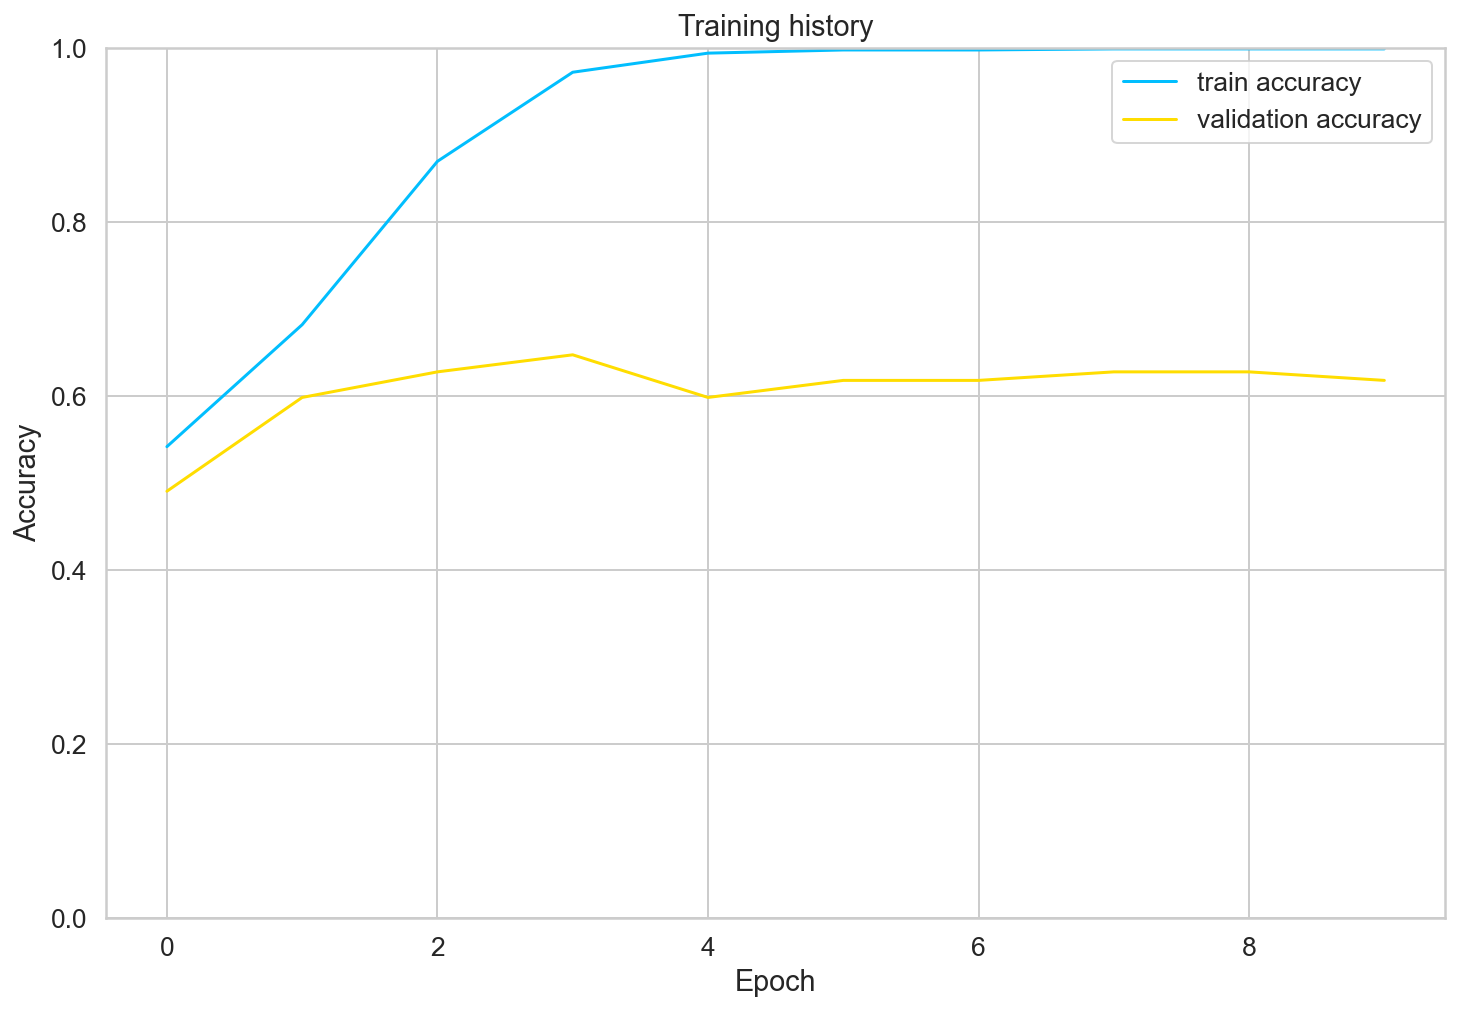

In [144]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### Evaluation

In [145]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

0.6019417475728155

In [154]:
def get_predictions(model, data_loader):
    model = model.eval()
    article_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    with torch.no_grad():
        for d in data_loader:
            texts = d["article_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            article_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(labels)
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return article_texts, predictions, prediction_probs, real_values

In [155]:
y_article_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [160]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    Negative       0.55      0.69      0.61        32
     Neutral       0.69      0.64      0.67        56
    Positive       0.36      0.27      0.31        15

    accuracy                           0.60       103
   macro avg       0.54      0.53      0.53       103
weighted avg       0.60      0.60      0.60       103



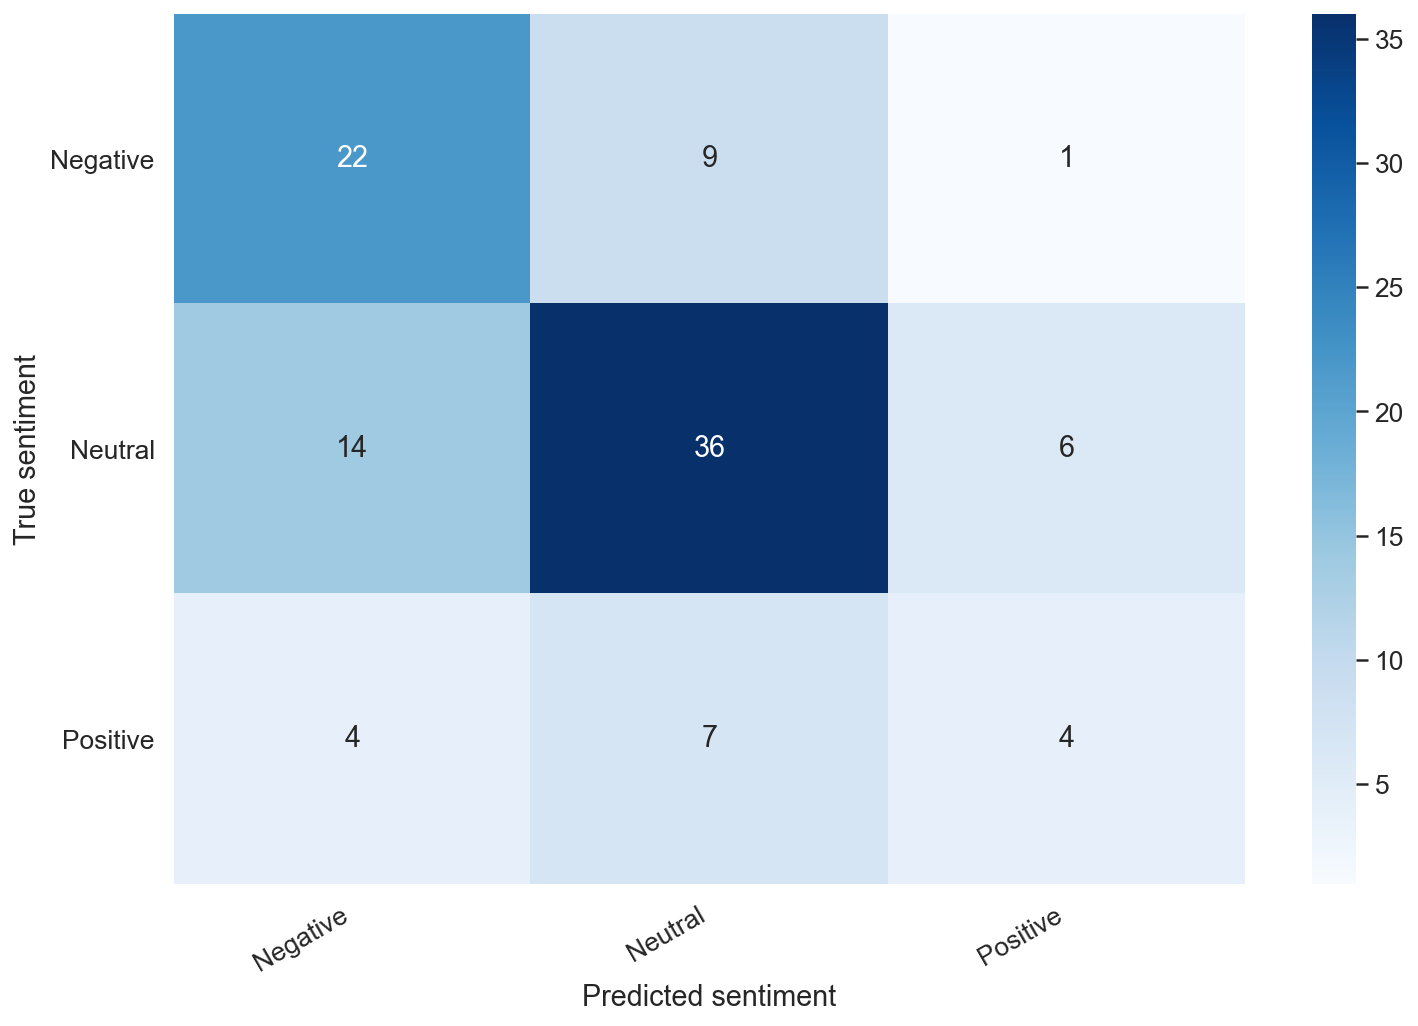

In [163]:
def show_confusion_matrix(confusion_matrix):
    
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment')

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

### Print example

In [164]:
idx = 2
article_text = y_article_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [167]:
print("\n".join(wrap(article_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

in Vilnius bijeen om een antwoord te formuleren op de dreigementen van
Gorbatsjov. Het liet in een telegram weten dat het geen reden ziet,
die de verslechtering van de economische relatie tussen Litouwen en
Moskou rechtvaardigt. Verder stelt het parlement dat het niet weet wat
Gorbatsjov voor concrete inhoud aan de maatregelen wil meegeven. De
volksvertegenwoordiging stelt dan ook voor dat een regeringsdelegatie
onder leiding van premier K. Pruskiene met Moskou gaat praten om tot
een oplossing te komen. De Litouwse president Landsbergis verklaarde
tijdens de zitting van het parlement dat het doel van de
onderhandelingen is „onafhankelijkheid te bereiken,

True sentiment: Neutral


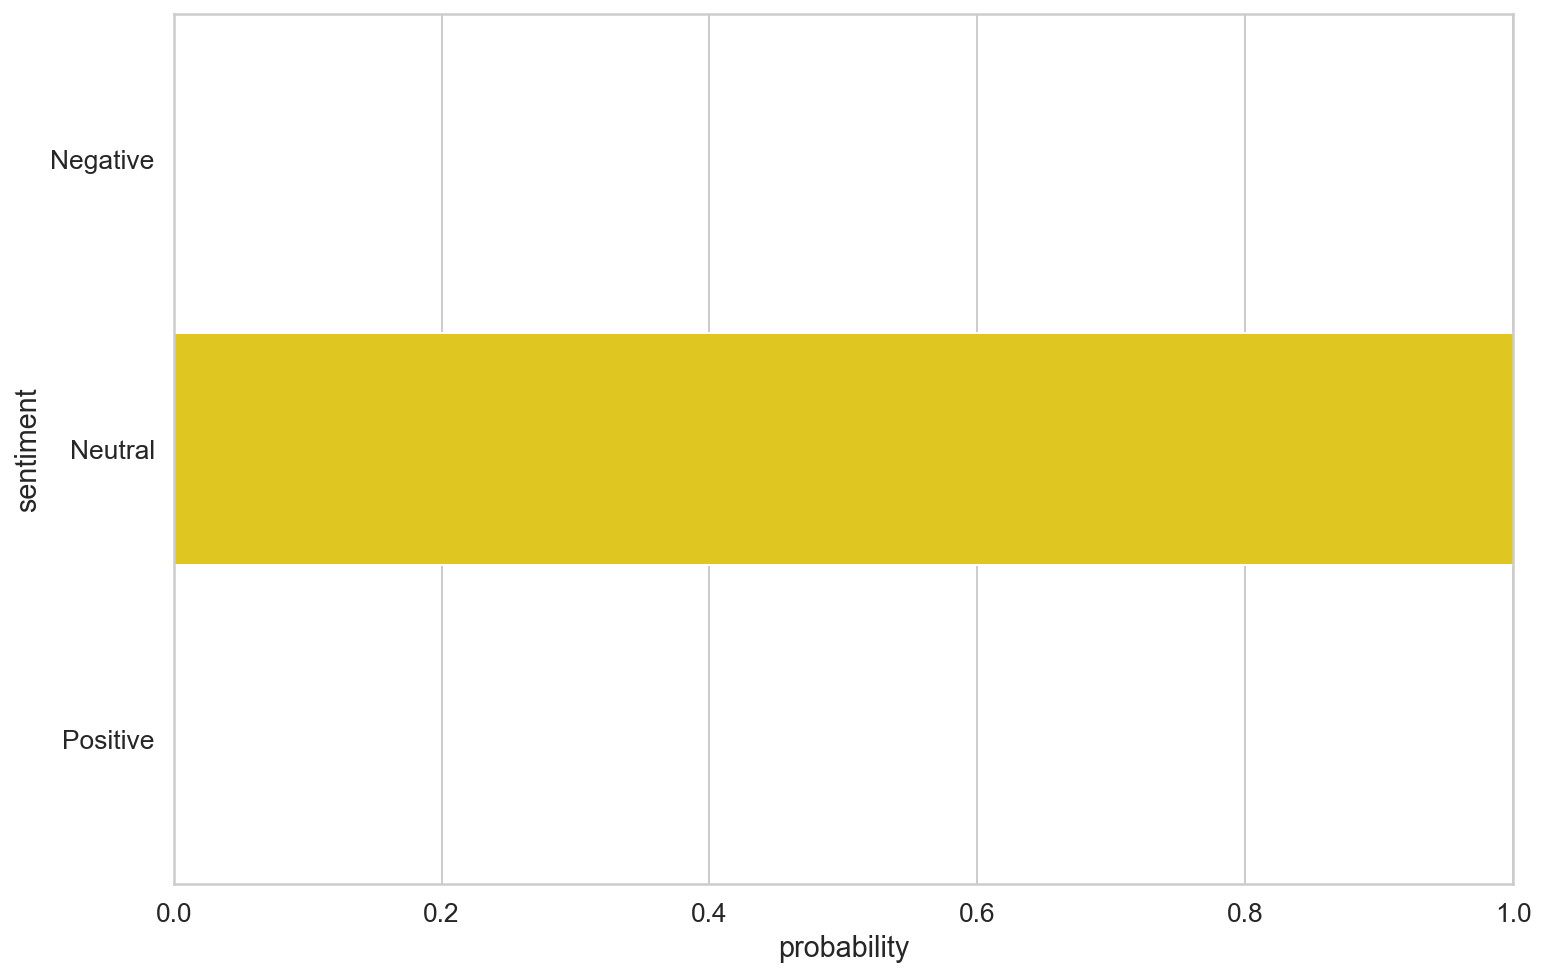

In [168]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

### Predicting new articles

In [169]:
encoded_article = tokenizer.encode_plus(
    article_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)

/Users/leonardovida/Library/Caches/pypoetry/virtualenvs/histaware-RplM6c3o-py3.8/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1938: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [178]:
input_ids = encoded_article['input_ids'].to(device)
attention_mask = encoded_article['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {article_text}')
print(f'Sentiment: {class_names[prediction]}')
print("-----------")

Review text: in Vilnius bijeen om een antwoord te formuleren op de dreigementen van Gorbatsjov. Het liet in een telegram weten dat het geen reden ziet, die de verslechtering van de economische relatie tussen Litouwen en Moskou rechtvaardigt. Verder stelt het parlement dat het niet weet wat Gorbatsjov voor concrete inhoud aan de maatregelen wil meegeven. De volksvertegenwoordiging stelt dan ook voor dat een regeringsdelegatie onder leiding van premier K. Pruskiene met Moskou gaat praten om tot een oplossing te komen. De Litouwse president Landsbergis verklaarde tijdens de zitting van het parlement dat het doel van de onderhandelingen is „onafhankelijkheid te bereiken,
Sentiment: Neutral
-----------
